# Principal Component Analysis

#### Aprendizaje Automático - Instituto de Computación - UdelaR

En este documento se presenta el Análisis de Componentes Principales (PCA), un método no supervisado para encontrar patrones en conjuntos de datos de alta dimensionalidad, y realizar reducción de dimensiones. PCA centra, rota y escala los datos, permitiendo eliminar algunas dimensiones de varianza baja, y de esta forma permitiendo también mejor performance para algunos métodos, así como una visualización exploratoria de los datos. 

El documento está basado en las siguientes referencias (y el código está principalmente tomado de la tercera): 

[A Beginner’s Guide to Eigenvectors, PCA, Covariance and Entropy](http://deeplearning4j.org/eigenvector)

[A tutorial on PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf)(Lindsay Smiths)

[PCA Step by step in Python](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html) (Sebastian Raschka)

Utilizaremos las bibliotecas Numpy y Matplotlib de Python para realizar una implementación de ejemplo.

In [217]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
np.set_printoptions(suppress=True,precision=3)
from matplotlib.patches import FancyArrowPatch

Definamos un dataset muy simple, con 6 personas, identificadas por su altura, peso, y la longitud de su dedo anular (?). Cada columna es una instancia con 3 atributos. Definiremos 3 mujeres y 3 hombres como referencia, pero utilizaremos todas las instancias juntas para realizar PCA. 

In [218]:
num_instances=6
X_men=np.array([[1.97,110,5],[1.80,70,4.8],[1.70,90,4.9]]).transpose()
X_women=np.array([[1.65,52,4.7],[1.75,65,4.8],[1.67,58,4.6]]).transpose()

# Por si queremos jugar con más instancias
#num_instances=20
#X_men = np.random.multivariate_normal([1.75,80,4.7], [[0.010,0,0],[0,1,0],[0,0,0.01]],num_instances).T
#X_women = np.random.multivariate_normal([1.60,70,4.7], [[0.010,0,0],[0,1,0],[0,0,0.01]],num_instances).T

#print (X_men)

X = np.hstack((X_men,X_women))
print (X)

[[  1.97   1.8    1.7    1.65   1.75   1.67]
 [110.    70.    90.    52.    65.    58.  ]
 [  5.     4.8    4.9    4.7    4.8    4.6 ]]


Para comenzar, calcularemos media y varianza de cada una de las columnas. 

La media es, por supuesto:

$$ \bar{X} = \frac{\sum_{i=n}^n X_i }{n} $$

Y la varianza mide qué tanto los datos se alejan de la media: 

$$ var(X) = \frac{\sum_{i=n}^n (X_i - \bar{X})(X_i - \bar{X}) }{n-1} $$



In [219]:
mean=np.mean(X,axis=1) #Observar que tomamos la media de cada fila, por eso axis=1
std=np.std(X,axis=1)
var=np.var(X,axis=1)

print ("Media:",mean)
print ("Varianza:",var)
print ("Desviación estándar:", std)





Media: [ 1.757 74.167  4.8  ]
Varianza: [  0.012 398.139   0.017]
Desviación estándar: [ 0.108 19.953  0.129]


La desviación estándar es simplemente la raíz cuadrada de la varianza (la utlizamos porque es comparable con la media).  Observemos que al tomar cuadrados, las desviaciones positivas y negativas de la media _no_ se cancelan. 

Reescalamos los valores. Para esto, restamos la media a cada dimensión (y nuestro conjunto queda centrado en (0,0,0)).

In [220]:
X_r = X - X.mean(axis=1,keepdims=True)
print (X_r)



[[  0.213   0.043  -0.057  -0.107  -0.007  -0.087]
 [ 35.833  -4.167  15.833 -22.167  -9.167 -16.167]
 [  0.2    -0.      0.1    -0.1    -0.     -0.2  ]]


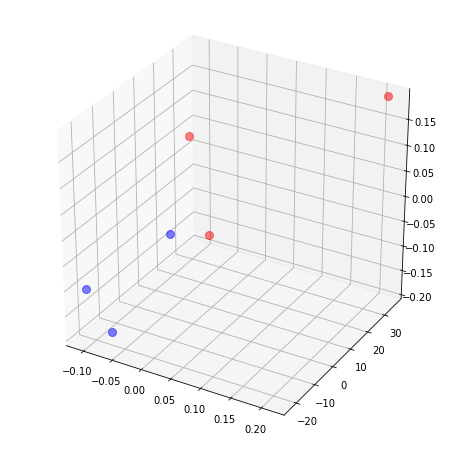

In [234]:



fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(X_r[0,0:int(num_instances/2)], X_r[1,0:int(num_instances/2)], X_r[2,0:int(num_instances/2)], 'o', markersize=8, color='red', alpha=0.5, label='class1')
ax.plot(X_r[0,int(num_instances/2):num_instances], X_r[1,int(num_instances/2):num_instances], X_r[2,int(num_instances/2):num_instances], 'o', markersize=8, color='blue', alpha=0.5, label='class2')

plt.show()


Volvemos a calcular media y varianza:

In [222]:
mean=np.mean(X_r,axis=1)
std=np.std(X_r,axis=1,ddof=1)
var=np.var(X_r,axis=1,ddof=1)

print ("Means:",mean)
print ("Standard deviations:",std)
print ("Variances:",var)
#mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

Means: [ 0. -0. -0.]
Standard deviations: [ 0.118 21.858  0.141]
Variances: [  0.014 477.767   0.02 ]


La covarianza se define como:

$$ cov(X, Y) = = \frac{\sum_{i=n}^n (X_i - \bar{X})(Y_i - \bar{Y}) }{n-1} $$


y es una medida estadística que mide cómo se relacionan dos dimensiones. Si la covarianza es positiva, indica que ambas dimensiones crecen juntas, mientras que si es negativa, indica que cuando una crece, la otra decrece. Si la covarianza es 0, entonces las dimensiones son independientes (es decir, modificar una no afecta a la otra). 

La matriz de covarianza tiene en cada elemento de la diagonal la varianza de la dimensión correspondiente, y en su elemento $ c_{ij}$ la covarianza de las dimensiones $i$ y $j$ (nótese que $cov(i,j)=cov(j,i)$ y por lo tanto la matriz es simétrica

In [223]:
cvm=np.cov(X_r)
print (cvm)

[[  0.014   2.079   0.013]
 [  2.079 477.767   2.84 ]
 [  0.013   2.84    0.02 ]]


Como la matriz es simétrica, sabemos que su valores propios son reales, así que vamos a calcularlos, y de esta forma obtendremos las direcciones en las que hay mayor varianza. Utilizamos para eso la función eig de Numpy.

In [224]:
eig_val_cov, eig_vec_cov = np.linalg.eig(cvm)

for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T

    print('Valor propio {} de la matriz de covarianza {}'.format(i+1, eig_val_cov[i]))
    print('Vector propio:')
    print(eigvec_cov)


Valor propio 1 de la matriz de covarianza 477.79259264371103
Vector propio:
[[0.004]
 [1.   ]
 [0.006]]
Valor propio 2 de la matriz de covarianza 0.005074426752244874
Vector propio:
[[ 0.95 ]
 [-0.006]
 [ 0.312]]
Valor propio 3 de la matriz de covarianza 0.002906262870038155
Vector propio:
[[-0.313]
 [-0.004]
 [ 0.95 ]]


Los vectores propios obtenidos nos indican las direcciones en las que los datos varían más. El vector con el mayor valor propio es el _componente principal_ de la matriz, es decir que muestra la dirección en la que los datos están más dispersos. Y así podemos continuar, viendo las dimensiones donde hay más variación, ordenando los vectores propios según sus valores propios. 

In [225]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i)
    #    print(i[0])



(477.79259264371103, array([0.004, 1.   , 0.006]))
(0.005074426752244874, array([ 0.95 , -0.006,  0.312]))
(0.002906262870038155, array([-0.313, -0.004,  0.95 ]))


Ahora reduciremos la dimensión de nuestro conjunto original para dejarlo en 2 dimensiones. Pero en lugar de seleccionar dos atributos, haremos antes un cambio de base para expresar cada punto como una combinación lineal de los dos componentes principales (es decir, los dos vectores propios con mayores valores propios). 

Para esto, construimos una matrix $W$ que tiene en sus columnas los vectores propios: 

In [226]:
# Just to principal components
matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
print('Matrix W:\n', matrix_w)



Matrix W:
 [[ 0.004  0.95 ]
 [ 1.    -0.006]
 [ 0.006  0.312]]


Transformar las instancias al nuevo subespacio es simplemente multiplicar nuestra matriz con las instancias por este vector $W$

In [227]:
# Transform instance to the new subspace

transformed = np.dot(X_r.T,matrix_w).transpose()
print (transformed)

[[ 35.834  -4.166  15.833 -22.167  -9.166 -16.168]
 [  0.05    0.066  -0.117   0.      0.049  -0.048]]


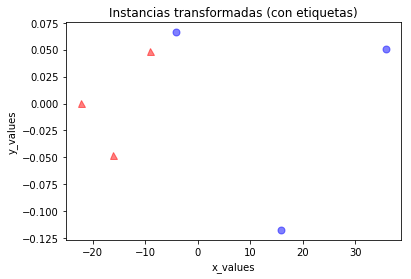

In [228]:
plt.plot(transformed[0,0:int(num_instances/2)], transformed[1,0:int(num_instances/2)], 'o', markersize=7, color='blue', alpha=0.5, label='men')
plt.plot(transformed[0,int(num_instances/2):num_instances], transformed[1,int(num_instances/2):num_instances], '^', markersize=7, color='red', alpha=0.5, label='women')
#plt.xlim([-4,4])
#plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
#plt.legend()
plt.title('Instancias transformadas (con etiquetas)')

plt.show()



Hemos obtenido un nuevo dataset con una dimensión menos, pero que respeta (tanto como es posible) la dispersión de los datos, porque tiene las dos dimensiones de mayor varianza.

Al ver los valores propios, observamos que uno de ellos era mucho mayor que los otros, así que puede tener sentido ver qué sucede si quitamos una dimensión más: 

In [229]:
# Just one dimension 
matrix_w2 = np.hstack((eig_pairs[0][1].reshape(3,1),))
print('Matrix W:\n', matrix_w2)



Matrix W:
 [[0.004]
 [1.   ]
 [0.006]]


In [230]:
transformed2 = np.dot(X_r.T,matrix_w2).transpose()
print (transformed2)

[[ 35.834  -4.166  15.833 -22.167  -9.166 -16.168]]


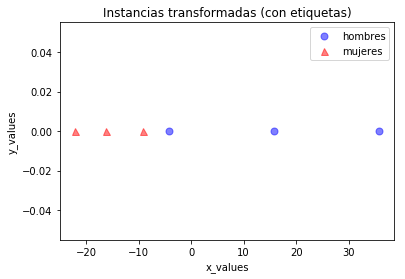

In [231]:
plt.plot(transformed2[0,0:int(num_instances/2)],np.zeros(int(num_instances/2)), 'o', markersize=7, color='blue', alpha=0.5, label='hombres')
plt.plot(transformed2[0,int(num_instances/2):num_instances],np.zeros(int(num_instances/2)), '^', markersize=7, color='red', alpha=0.5, label='mujeres')
#plt.xlim([-4,4])
#plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Instancias transformadas (con etiquetas)')

plt.show()